In [1]:
from lenskit.metrics import dataGenerator
from lenskit import batch, topn, util, topnFair
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, user_knn as knn
from lenskit import topn, topnFair

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
import math

In [4]:
#ratings = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
#                      names=['user', 'item', 'rating', 'timestamp'], header=0)

#items = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
#                      names=['movieId','title','genres'], header=0)

ratings = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/ratings.csv', sep=',',
                      names=['user', 'item', 'rating', 'timestamp'], header=0)

items = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
                      names=['item','title','genres'], header=0)

#C:\Users\josse\Git-kode projects\Speciale\Fair-Recommendations\ml-latest-small\ratings.csv

In [5]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
item      9125 non-null int64
title     9125 non-null object
genres    9125 non-null object
dtypes: int64(1), object(2)
memory usage: 213.9+ KB


In [6]:
items_dummy = pd.concat([items, items['genres'].str.get_dummies(sep='|')], axis=1)
items_dummy.head()

,item,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
algo_ii = knn.UserUser(20)
algo_als = als.BiasedMF(50)

In [8]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [9]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 1, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))
   
    

In [10]:
test_data = pd.concat(test_data, ignore_index=True)
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs_joined = all_recs.join(items_dummy.set_index('item'), on='item')
all_recs_joined.head()

,item,score,user,rank,Algorithm,title,genres,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,91104,5.658088,1,1,ItemItem,"Twilight Saga: Breaking Dawn - Part 1, The (2011)",Adventure|Drama|Fantasy|Romance,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,107559,5.187500,1,2,ItemItem,Am Ende eiens viel zu kurzen Tages (Death of a...,Animation|Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,73290,5.187500,1,3,ItemItem,Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's ...,Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,106441,5.187500,1,4,ItemItem,"Book Thief, The (2013)",Children|Drama|War,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3216,5.063655,1,5,ItemItem,"Vampyros Lesbos (Vampiras, Las) (1971)",Fantasy|Horror|Thriller,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [11]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

,user,item,rating
0,1,2968,1.0
1,1,2150,3.0
2,1,2294,2.0
3,1,1263,2.0
4,2,223,1.0


In [12]:
_protected_group2 = all_recs_joined.loc[all_recs_joined['Drama'] == 1]
_protected_group2.head()
_protected_group2['item'].values

array([ 91104, 107559,  73290, ...,   1178,   1175,   1957], dtype=int64)

In [13]:
recs_temp = all_recs_joined.iloc[100:110,:]
recs_temp 


,item,score,user,rank,Algorithm,title,genres,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
100,107559,6.122951,2,1,ItemItem,Am Ende eiens viel zu kurzen Tages (Death of a...,Animation|Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,106441,6.122951,2,2,ItemItem,"Book Thief, The (2013)",Children|Drama|War,0,0,0,...,0,0,0,0,0,0,0,0,1,0
102,86781,6.018171,2,3,ItemItem,Incendies (2010),Drama|Mystery|War,0,0,0,...,0,0,0,0,1,0,0,0,1,0
103,3320,6.018171,2,4,ItemItem,Mifune's Last Song (Mifunes sidste sang) (1999),Comedy|Drama|Romance,0,0,0,...,0,0,0,0,0,1,0,0,0,0
104,5071,6.018171,2,5,ItemItem,Maelström (2000),Drama|Romance,0,0,0,...,0,0,0,0,0,1,0,0,0,0
105,4731,6.018171,2,6,ItemItem,Innocence (2000),Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,3216,5.999106,2,7,ItemItem,"Vampyros Lesbos (Vampiras, Las) (1971)",Fantasy|Horror|Thriller,0,0,0,...,0,1,0,0,0,0,0,1,0,0
107,4754,5.999106,2,8,ItemItem,"Wicker Man, The (1973)",Drama|Horror|Mystery|Thriller,0,0,0,...,0,1,0,0,1,0,0,1,0,0
108,92494,5.999106,2,9,ItemItem,Dylan Moran: Monster (2004),Comedy|Documentary,0,0,0,...,0,0,0,0,0,0,0,0,0,0
109,73290,5.967975,2,10,ItemItem,Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's ...,Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def calculate_demParity(recs, protected_group): 
    #beslut hvad der er nemmest. Skal denne tage "protected group". contains eller tage en protected variabel?
    
    exposure_pro = 0; 
    exposure_unpro = 0;
    print(_protected_group2['item'].values)

    for index, row in recs.iterrows():
        if row["item"] in _protected_group2['item'].values:
            print(row["item"], "in protected group")
            exposure_pro = exposure_pro + (1/math.log2(1+row["rank"])) 
        else:
            exposure_unpro = exposure_unpro + (1/math.log2(1+row["rank"]))  
   
    return abs(exposure_pro-exposure_unpro)

In [15]:
x = calculate_demParity(recs_temp, _protected_group2)
x 

[ 91104 107559  73290 ...   1178   1175   1957]
107559 in protected group
106441 in protected group
86781 in protected group
3320 in protected group
5071 in protected group
4731 in protected group
4754 in protected group
73290 in protected group


3.2748326800937173

In [16]:
# user , algorithms = iput to group_cols --> de koloner der skal  groupes på 
# res: categories of protected variable 
res= list(all_recs_joined.iloc[:,8:])
res1= all_recs_joined.item.nunique()
res2 =  all_recs_joined.loc[ all_recs_joined['Drama'] == 1]
print(res)

rla = topnFair.FairRecListAnalysis(['user', "Algorithm"])
rla.add_metric("rND")
rla.add_metric("rKL")
rla.add_metric("rRD")
rla.add_metric("div")
rla.add_metric("dem_parity")
results = rla.compute(all_recs_joined, test_data, "Drama", res, res1, res2.item.nunique())
results.head()

['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


rND       rKL       rRD       div  dem_parity
user Algorithm                                                    
1    ALS        0.042086  0.003884  0.127385  1.000000    1.206305
     ItemItem   0.057604  0.006576  0.154152  0.947368    1.368140
2    ALS        0.132245  0.034561  0.516994  1.000000    0.792569
     ItemItem   0.161561  0.083245  0.000000  0.894737    1.473249
3    ALS        0.406357  0.317214  0.000000  1.000000    2.153526

In [20]:
results.groupby('Algorithm').mean()

,rND,rKL,rRD,div,dem_parity
Algorithm,,,,,
ALS,0.176265,0.083231,0.106754,0.982352,1.568675
ItemItem,0.138453,0.060138,0.240759,0.916542,1.104084


In [17]:
results.groupby('Algorithm').rND.mean()

Algorithm
ALS         0.176265
ItemItem    0.138453
Name: rND, dtype: float64

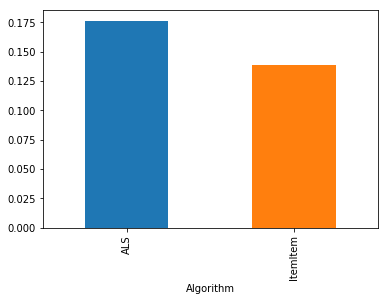

In [18]:
results.groupby('Algorithm').rND.mean().plot.bar()


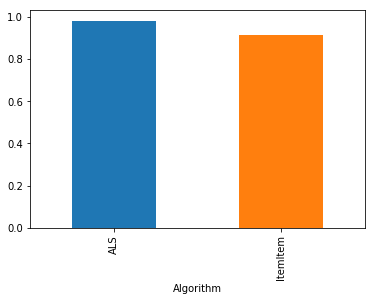

In [19]:
results.groupby('Algorithm').div.mean().plot.bar()